### Setup

In [ ]:
%pip install spuco

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 33.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.4/127.4 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.2/126.2 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.2 MB/s eta 0:00:00
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39588 sha256=4d4b6482461171be732ad2c44d54d01c08b2ca15a84487f46e3e3b788d4bcaf0
  Stored in directory: /root/.cache/pip/wheels/50/b0/82/1f97b5348c7fe9f0ce0ba18497202cafa5dec4562bd5292680
Successfully built grad-cam


In [ ]:
import torch
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from spuco.robust_train import ERM
from spuco.datasets import SpuCoMNIST, SpuriousFeatureDifficulty
from spuco.models import model_factory
from spuco.utils import set_seed, CustomIndicesSampler, Trainer
from spuco.group_inference import JTTInference
from spuco.evaluate import Evaluator
import torchvision.transforms as T
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
import numpy as np



device = torch.device("cuda")

In [ ]:

set_seed(0)

### Dataset Creation

In [ ]:


classes = [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9]]
difficulty = SpuriousFeatureDifficulty.MAGNITUDE_LARGE

trainset= SpuCoMNIST(
    root="/data/mnist/",
    spurious_feature_difficulty=difficulty,
    spurious_correlation_strength=0.95,
    classes=classes,
    split="train",
    label_noise=0.001
)
trainset.initialize()

testset = SpuCoMNIST(
    root="/data/mnist/",
    spurious_feature_difficulty=difficulty,
    classes=classes,
    split="test"
)
testset.initialize()


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 14.8MB/s]


Extracting /data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 499kB/s]


Extracting /data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]


Extracting /data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 9.71MB/s]


Extracting /data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/mnist/MNIST/raw



In [ ]:

classes = [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9]]

valset = SpuCoMNIST(
    root="/data/mnist/",
    spurious_feature_difficulty=difficulty,
    classes=classes,
    split="val"
)
valset.initialize()


In [ ]:
T.ToPILImage()(trainset[1000][0]).resize((28,28))

In [ ]:
T.ToPILImage()(trainset[1000][0])

### Investigate Forgettability

In [ ]:
train_loader= DataLoader(trainset, batch_size=64, shuffle=True)
not_shuffle_train_loader = DataLoader(trainset, batch_size=64, shuffle=False)
test_loader = DataLoader(testset, batch_size=64, shuffle=False)

In [ ]:


# model = model_factory("lenet", trainset[0][0].shape, trainset.num_classes).to(device)
model = model_factory("mlp", trainset[0][0].shape, trainset.num_classes).to(device)

# Initialize the model and optimizer
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, nesterov=False)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()
num_epochs = 10
# train_predictions_history = [[] for _ in range(len(trainset))]
# test_predictions_history = [[] for _ in range(len(testset))]
train_acc_history_lst = []
test_acc_history_lst = []

# Training function
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

# Evaluation function - MIRELLE GEORGE
def evaluate(model, data_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    predictions = []
    acc_history = []
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            acc_history.extend((predicted == target).cpu().numpy())
            predictions.extend(predicted.cpu().numpy())
    return correct / total, acc_history

# Calculate forgetability scores - MIRELLE GEORGE
def calculate_forgetability(predictions_history):
    forgetability_scores = []
    for sample_predictions in predictions_history:
        correct_to_incorrect = 0
        for i in range(1, len(sample_predictions)):
            if sample_predictions[i-1] == 1 and sample_predictions[i] == 0:
                correct_to_incorrect += 1

        if sum(sample_predictions) == 0:
            correct_to_incorrect = (num_epochs // 2) + 1
        forgetability_scores.append(correct_to_incorrect)
    return forgetability_scores

In [ ]:
for epoch in range(num_epochs):
    train(model, train_loader, optimizer, criterion, device)
    train_acc, train_acc_history = evaluate(model, not_shuffle_train_loader, criterion, device)
    test_acc, test_acc_history = evaluate(model, test_loader, criterion, device)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

    train_acc_history_lst.append(train_acc_history)
    test_acc_history_lst.append(test_acc_history)

Epoch 1/10, Train Acc: 0.9508, Test Acc: 0.2309
Epoch 2/10, Train Acc: 0.9526, Test Acc: 0.2679
Epoch 3/10, Train Acc: 0.9533, Test Acc: 0.2732
Epoch 4/10, Train Acc: 0.9557, Test Acc: 0.3101
Epoch 5/10, Train Acc: 0.9558, Test Acc: 0.3151
Epoch 6/10, Train Acc: 0.9577, Test Acc: 0.3411
Epoch 7/10, Train Acc: 0.9587, Test Acc: 0.3586
Epoch 8/10, Train Acc: 0.9603, Test Acc: 0.4007
Epoch 9/10, Train Acc: 0.9608, Test Acc: 0.3787
Epoch 10/10, Train Acc: 0.9645, Test Acc: 0.4432


In [ ]:
## Find JTT predictions for each data point in train_loader
final_train_acc_history = train_acc_history_lst[-1]

## Find forgetability scores for each data point in train_loader
train_acc_history_transposed = np.array(train_acc_history_lst).T
forgettable_scores_per_datapoint = calculate_forgetability(train_acc_history_transposed)

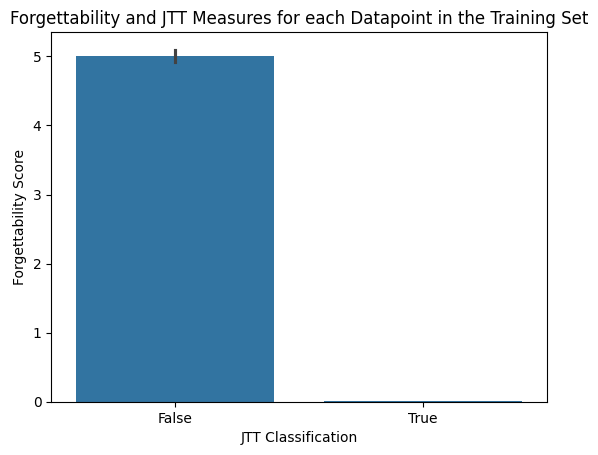

In [ ]:
index = np.arange(len(trainset))
trainset_df = pd.DataFrame({"index": index, "JTT": final_train_acc_history, "forgettability_scores": forgettable_scores_per_datapoint})

sns.barplot(data = trainset_df, x="JTT", y="forgettability_scores")
plt.title('Forgettability and JTT Measures for each Datapoint in the Training Set')
plt.xlabel('JTT Classification')
plt.ylabel('Forgettability Score')
plt.show()

mean_forgettability_JTT_1 = np.mean(trainset_df[trainset_df["JTT"] == 1]['forgettability_scores'])

In [ ]:

# Initialize group_labels as a NumPy array with the same size as the training set
group_labels = np.empty(len(trainset), dtype=object)  # Use `object` type to store tuples

# Populate group_labels with group assignments
for group, members in trainset.group_partition.items():
    # Assign the group label (tuple) to each datapoint in `members`
    for idx in members:
        group_labels[idx] = group

trainset_df["group_label"] = group_labels

# Function to classify group labels as "majority" or "minority"
def classify_group(group_label):
    if group_label[0] == group_label[1]:
        return "majority"
    else:
        return "minority"

# Apply the function to the 'group_label' column and create a new column 'class_type'
trainset_df["class_type"] = trainset_df["group_label"].apply(classify_group)

# Display the updated DataFrame
trainset_df

,index,JTT,forgettability_scores,group_label,class_type
0,0,True,0,"(2, 2)",majority
1,1,True,0,"(0, 0)",majority
2,2,True,0,"(2, 2)",majority
3,3,True,0,"(0, 0)",majority
4,4,True,0,"(4, 4)",majority
...,...,...,...,...,...
47999,47999,True,0,"(4, 4)",majority
48000,48000,True,0,"(1, 1)",majority
48001,48001,True,0,"(2, 2)",majority
48002,48002,True,0,"(3, 3)",majority


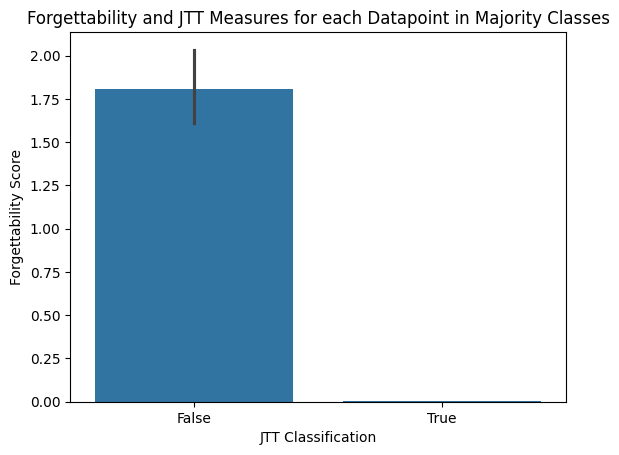

In [ ]:
trainset_df_majority = trainset_df[trainset_df["class_type"] == "majority"]
trainset_df_minority = trainset_df[trainset_df["class_type"] == "minority"]

sns.barplot(data = trainset_df_majority, x="JTT", y="forgettability_scores")
plt.title('Forgettability and JTT Measures for each Datapoint in Majority Classes')
plt.xlabel('JTT Classification')
plt.ylabel('Forgettability Score')
plt.show()

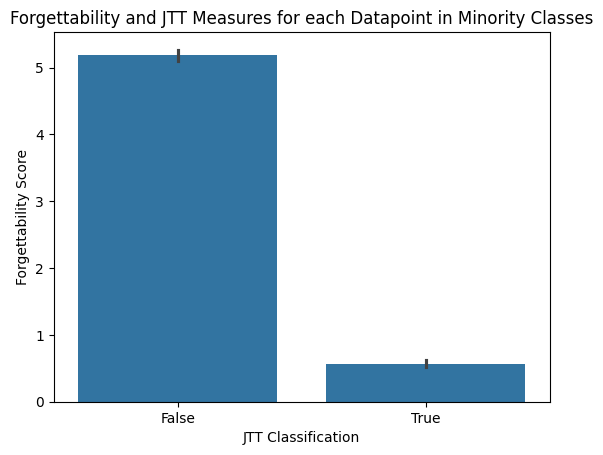

In [ ]:
sns.barplot(data = trainset_df_minority, x="JTT", y="forgettability_scores")
plt.title('Forgettability and JTT Measures for each Datapoint in Minority Classes')
plt.xlabel('JTT Classification')
plt.ylabel('Forgettability Score')
plt.show()

In [ ]:
for group, members in trainset.group_partition.items():
    print(f"Group: {group}, Members: {members}, Type: {type(members)}")

Group: (2, 2), Members: [0, 2, 9, 10, 17, 23, 32, 44, 50, 55, 57, 58, 77, 83, 95, 107, 115, 118, 123, 133, 134, 136, 142, 144, 149, 157, 159, 176, 178, 189, 192, 197, 207, 212, 215, 216, 217, 218, 220, 225, 228, 230, 232, 233, 236, 245, 250, 263, 267, 271, 287, 292, 295, 296, 299, 301, 302, 314, 319, 320, 326, 327, 328, 331, 334, 347, 348, 364, 366, 389, 394, 403, 404, 405, 423, 428, 429, 448, 454, 462, 467, 482, 483, 486, 488, 490, 494, 505, 515, 519, 520, 526, 528, 542, 544, 546, 551, 553, 558, 559, 560, 563, 572, 573, 574, 577, 581, 591, 593, 595, 596, 601, 612, 616, 619, 637, 639, 644, 653, 665, 669, 670, 671, 672, 680, 682, 683, 684, 685, 688, 704, 716, 719, 725, 731, 733, 734, 738, 742, 756, 758, 766, 773, 776, 779, 792, 794, 795, 797, 806, 808, 823, 828, 830, 834, 836, 846, 856, 864, 868, 875, 877, 884, 885, 894, 895, 896, 915, 917, 931, 941, 942, 947, 948, 951, 954, 961, 968, 973, 977, 979, 982, 985, 987, 1003, 1004, 1009, 1013, 1016, 1018, 1020, 1026, 1028, 1029, 1031, 1034, 1

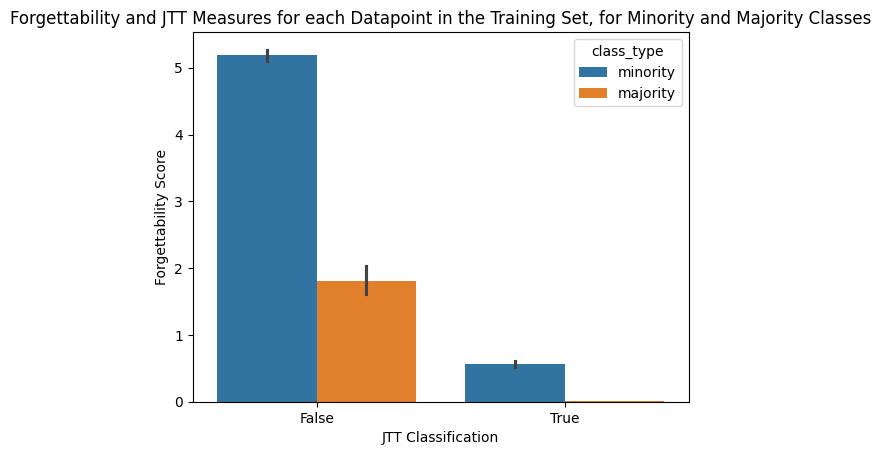

In [ ]:
sns.barplot(trainset_df, x="JTT", y="forgettability_scores", hue="class_type")
plt.title('Forgettability and JTT Measures for each Datapoint in the Training Set, for Minority and Majority Classes');
plt.xlabel('JTT Classification');
plt.ylabel('Forgettability Score');

In [ ]:
# train_acc_history_lst = []
# test_acc_history_lst = []

# for epoch in range(num_epochs):
#     train(model, train_loader, optimizer, criterion, device)
#     train_acc, train_acc_history = evaluate(model, not_shuffle_train_loader, criterion, device)
#     test_acc, test_acc_history = evaluate(model, test_loader, criterion, device)

#     print(f"Epoch {epoch+1}/{num_epochs}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

#     train_acc_history_lst.append(train_acc_history)
#     test_acc_history_lst.append(test_acc_history)

(2, 2) 0.008537013214828675
(0, 0) 0.008942497660393053
(4, 4) 0.00859854829704076
(1, 1) 0.005772791634898159
(3, 3) 0.007891891891891892
(0, 3) 3.408450704225352
(4, 0) 1.872
(3, 1) 4.512820512820513
(1, 2) 2.171171171171171
(0, 2) 2.488372093023256
(2, 0) 3.7131147540983607
(0, 4) 1.4883720930232558
(1, 3) 4.416666666666667
(3, 2) 2.2205882352941178
(0, 1) 3.4615384615384617
(3, 0) 2.432
(2, 4) 6.0
(4, 1) 5.948717948717949
(4, 3) 4.224806201550388
(3, 4) 4.778688524590164
(1, 0) 2.3149606299212597
(2, 3) 3.432
(2, 1) 3.2181818181818183
(1, 4) 5.133333333333334
(4, 2) 6.0


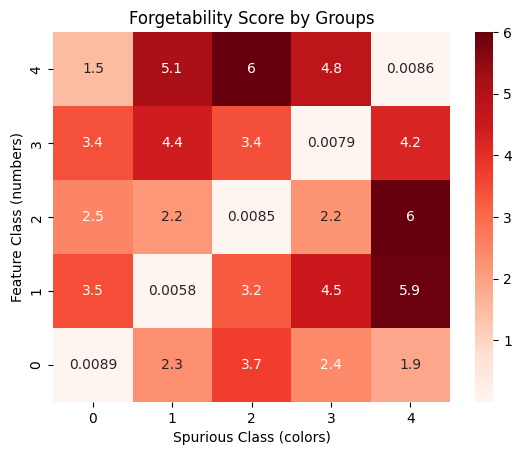

In [ ]:
# DONE BY MIRELLE GEORGE
train_acc_history_lst_transpose = np.array(train_acc_history_lst).T
train_forgettability_scores=calculate_forgetability(train_acc_history_lst_transpose)
train_forgettability_scores=np.array(train_forgettability_scores)

rows = 5
cols = 5

data = []
for _ in range(rows):
    row = []
    for _ in range(cols):
        row.append(0)
    data.append(row)

for group, members in trainset.group_partition.items():
    group_score = train_forgettability_scores[members]
    gs_mean = group_score.mean()
    data[group[1]][group[0]] = gs_mean
    print(group,gs_mean)

hm = sns.heatmap(data = data, xticklabels=True, yticklabels=True, annot = True, cmap="Reds")
hm.invert_yaxis()
plt.xlabel('Spurious Class (colors)')
plt.ylabel('Feature Class (numbers)')
plt.title('Forgetability Score by Groups')
plt.show()

Robust Training with Forgetting-Based Upsampling

In [ ]:

def group_data(forgetability_scores, num_groups=6):
    #groups data directly based on forgetting score

    min_score = min(forgetability_scores)
    max_score = max(forgetability_scores)
    bins = np.linspace(min_score, max_score, num_groups + 1)
    print(bins)

    group_indices = np.digitize(forgetability_scores, bins)

    grouped_data = {}
    for i, score in enumerate(forgetability_scores):
      group = group_indices[i]
      if group not in grouped_data:
          grouped_data[group] = []
      grouped_data[group].append(i)
    return grouped_data


def group_data_binary(forgetability_scores, num_groups=2):
    #group data into 2 based on if forgettability floored is 0 or not
    grouped_data = {0: [], 1: []}
    for i, score in enumerate(forgetability_scores):
        if int(score) == 0:
            grouped_data[0].append(i)
        else:
            grouped_data[1].append(i)
    return grouped_data

grouped_data_indices = group_data(train_forgettability_scores, num_groups=6)

grouped_data_indices_binary = group_data_binary(train_forgettability_scores, num_groups=1)

for group, members in grouped_data_indices.items():
    print(f"Group {group}: {len(members)} data points")

for group, members in grouped_data_indices_binary.items():
    print(f"Group {group}: {len(members)} data points")

# Create a new dataset with samples in each group, upsampled to the maximum group size
len_max_group = max([len(grouped_data_indices[key]) for key in grouped_data_indices.keys()])
indices = []
for key in grouped_data_indices.keys():
    group_reordered_indices = [grouped_data_indices[key][i] for i in torch.randperm(len(grouped_data_indices[key])).tolist()]
    group_indices = []
    while len(group_indices) < len_max_group:
        group_indices.extend(group_reordered_indices)
    indices.extend(group_indices[:len_max_group])
print(len_max_group)

len_max_group = max([len(grouped_data_indices_binary[key]) for key in grouped_data_indices_binary.keys()])
indices_binary = []
for key in grouped_data_indices_binary.keys():
    group_reordered_indices_binary = [grouped_data_indices_binary[key][i] for i in torch.randperm(len(grouped_data_indices_binary[key])).tolist()]
    group_indices_binary = []
    while len(group_indices_binary) < len_max_group:
        group_indices_binary.extend(group_reordered_indices_binary)
    indices_binary.extend(group_indices_binary[:len_max_group])
print(len_max_group)

# Create the new data loaders with indices to upsample
upsampled_train_loader = DataLoader(trainset, batch_size=64, shuffle=False, sampler=CustomIndicesSampler(indices=indices, shuffle=True))
upsampled_train_loader_binary = DataLoader(trainset, batch_size=64, shuffle=False, sampler=CustomIndicesSampler(indices=indices_binary, shuffle=True))


[0. 1. 2. 3. 4. 5. 6.]
Group 1: 45740 data points
Group 7: 1333 data points
Group 2: 687 data points
Group 3: 201 data points
Group 4: 43 data points
Group 0: 45740 data points
Group 1: 2264 data points
45740
45740


In [ ]:
#reset train lists, model, optimizer
train_acc_history_lst_forgetting = []
test_acc_history_lst_forgetting = []

model_forgetting = model_factory("mlp", trainset[0][0].shape, trainset.num_classes).to(device)
optimizer_forgetting = optim.SGD(model_forgetting.parameters(), lr=1e-3, momentum=0.9, nesterov=False)


# Use upsampled_train_loader for training
for epoch in range(num_epochs):
    train(model_forgetting, upsampled_train_loader, optimizer_forgetting, criterion, device)
    train_acc, train_acc_history = evaluate(model_forgetting, upsampled_train_loader, criterion, device)
    test_acc, test_acc_history = evaluate(model_forgetting, test_loader, criterion, device)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

    train_acc_history_lst_forgetting.append(train_acc_history)
    test_acc_history_lst_forgetting.append(test_acc_history)

Epoch 1/10, Train Acc: 0.8397, Test Acc: 0.6303
Epoch 2/10, Train Acc: 0.9519, Test Acc: 0.7649
Epoch 3/10, Train Acc: 0.9812, Test Acc: 0.7942
Epoch 4/10, Train Acc: 0.9914, Test Acc: 0.8110
Epoch 5/10, Train Acc: 0.9958, Test Acc: 0.8420
Epoch 6/10, Train Acc: 0.9968, Test Acc: 0.8129
Epoch 7/10, Train Acc: 0.9984, Test Acc: 0.8126
Epoch 8/10, Train Acc: 0.9982, Test Acc: 0.8210
Epoch 9/10, Train Acc: 0.9987, Test Acc: 0.8201
Epoch 10/10, Train Acc: 0.9985, Test Acc: 0.8204


In [ ]:
#reset train lists, model, optimizer
train_acc_history_lst_forgetting_bin = []
test_acc_history_lst_forgetting_bin = []

model_bin = model_factory("mlp", trainset[0][0].shape, trainset.num_classes).to(device)
optimizer_bin = optim.SGD(model_bin.parameters(), lr=1e-3, momentum=0.9, nesterov=False)


# Use upsampled_train_loader for training
for epoch in range(num_epochs):
    train(model_bin, upsampled_train_loader_binary, optimizer_bin, criterion, device)
    train_acc, train_acc_history = evaluate(model_bin, upsampled_train_loader_binary, criterion, device)
    test_acc, test_acc_history = evaluate(model_bin, test_loader, criterion, device)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

    train_acc_history_lst_forgetting_bin.append(train_acc_history)
    test_acc_history_lst_forgetting_bin.append(test_acc_history)

Epoch 1/10, Train Acc: 0.6186, Test Acc: 0.3906
Epoch 2/10, Train Acc: 0.7604, Test Acc: 0.6496
Epoch 3/10, Train Acc: 0.8301, Test Acc: 0.6937
Epoch 4/10, Train Acc: 0.8972, Test Acc: 0.7660
Epoch 5/10, Train Acc: 0.9405, Test Acc: 0.7780
Epoch 6/10, Train Acc: 0.9627, Test Acc: 0.7924
Epoch 7/10, Train Acc: 0.9781, Test Acc: 0.8005
Epoch 8/10, Train Acc: 0.9897, Test Acc: 0.8230
Epoch 9/10, Train Acc: 0.9884, Test Acc: 0.8270
Epoch 10/10, Train Acc: 0.9917, Test Acc: 0.8145


In [ ]:
model_jtt = model_factory("mlp", trainset[0][0].shape, trainset.num_classes).to(device)
optimizer_jtt = optim.SGD(model_jtt.parameters(), lr=1e-3, momentum=0.9, nesterov=False)


trainer = Trainer(
    trainset=trainset,
    model=model_jtt,
    batch_size=64,
    optimizer=optimizer_jtt,
    device=device,
    verbose=True
)

trainer.train(1)


predictions = torch.argmax(trainer.get_trainset_outputs(), dim=-1).detach().cpu().tolist()
jtt = JTTInference(
    predictions=predictions,
    class_labels=trainset.labels
)
group_partition = jtt.infer_groups()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 0:   2%|▏         | 14/751 [00:00<00:14, 52.15batch/s, accuracy=70.3125%, loss=1.4] 

 | Epoch 0 | Loss: 1.6315945386886597 | Accuracy: 7.8125%
 | Epoch 0 | Loss: 1.629549264907837 | Accuracy: 12.5%
 | Epoch 0 | Loss: 1.6245113611221313 | Accuracy: 15.625%
 | Epoch 0 | Loss: 1.6299986839294434 | Accuracy: 9.375%
 | Epoch 0 | Loss: 1.5896592140197754 | Accuracy: 23.4375%
 | Epoch 0 | Loss: 1.6047457456588745 | Accuracy: 17.1875%
 | Epoch 0 | Loss: 1.6085692644119263 | Accuracy: 17.1875%
 | Epoch 0 | Loss: 1.5802440643310547 | Accuracy: 26.5625%
 | Epoch 0 | Loss: 1.5801992416381836 | Accuracy: 21.875%
 | Epoch 0 | Loss: 1.5854880809783936 | Accuracy: 26.5625%
 | Epoch 0 | Loss: 1.585250735282898 | Accuracy: 31.25%
 | Epoch 0 | Loss: 1.5484070777893066 | Accuracy: 40.625%
 | Epoch 0 | Loss: 1.5557129383087158 | Accuracy: 40.625%
 | Epoch 0 | Loss: 1.54139244556427 | Accuracy: 53.125%
 | Epoch 0 | Loss: 1.53076171875 | Accuracy: 51.5625%
 | Epoch 0 | Loss: 1.5188159942626953 | Accuracy: 50.0%
 | Epoch 0 | Loss: 1.507048487663269 | Accuracy: 59.375%
 | Epoch 0 | Loss: 1.510

Epoch 0:   6%|▌         | 45/751 [00:00<00:06, 104.83batch/s, accuracy=95.3125%, loss=0.893]

 | Epoch 0 | Loss: 1.3463844060897827 | Accuracy: 76.5625%
 | Epoch 0 | Loss: 1.3776124715805054 | Accuracy: 59.375%
 | Epoch 0 | Loss: 1.359575867652893 | Accuracy: 70.3125%
 | Epoch 0 | Loss: 1.321457862854004 | Accuracy: 73.4375%
 | Epoch 0 | Loss: 1.345926284790039 | Accuracy: 67.1875%
 | Epoch 0 | Loss: 1.269155740737915 | Accuracy: 81.25%
 | Epoch 0 | Loss: 1.2507795095443726 | Accuracy: 78.125%
 | Epoch 0 | Loss: 1.3049582242965698 | Accuracy: 68.75%
 | Epoch 0 | Loss: 1.271910309791565 | Accuracy: 73.4375%
 | Epoch 0 | Loss: 1.2520831823349 | Accuracy: 75.0%
 | Epoch 0 | Loss: 1.2355180978775024 | Accuracy: 81.25%
 | Epoch 0 | Loss: 1.2286298274993896 | Accuracy: 79.6875%
 | Epoch 0 | Loss: 1.2602888345718384 | Accuracy: 79.6875%
 | Epoch 0 | Loss: 1.2511307001113892 | Accuracy: 78.125%
 | Epoch 0 | Loss: 1.2543935775756836 | Accuracy: 71.875%
 | Epoch 0 | Loss: 1.1342687606811523 | Accuracy: 93.75%
 | Epoch 0 | Loss: 1.1436896324157715 | Accuracy: 89.0625%
 | Epoch 0 | Loss: 1

Epoch 0:  10%|█         | 78/751 [00:00<00:05, 132.74batch/s, accuracy=96.875%, loss=0.513] 

 | Epoch 0 | Loss: 0.8934930562973022 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 1.0101760625839233 | Accuracy: 82.8125%
 | Epoch 0 | Loss: 0.8880354166030884 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.9555026292800903 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.8314305543899536 | Accuracy: 98.4375%
 | Epoch 0 | Loss: 0.8690094351768494 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.869179368019104 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.877598762512207 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.7368341088294983 | Accuracy: 100.0%
 | Epoch 0 | Loss: 0.8651109933853149 | Accuracy: 89.0625%
 | Epoch 0 | Loss: 0.837452232837677 | Accuracy: 90.625%
 | Epoch 0 | Loss: 0.7230631709098816 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.777238130569458 | Accuracy: 92.1875%
 | Epoch 0 | Loss: 0.7431835532188416 | Accuracy: 92.1875%
 | Epoch 0 | Loss: 0.7393561601638794 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.6792259812355042 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.6532847881317139 | Accuracy: 96.875%
 | Epoch 0 

Epoch 0:  15%|█▍        | 111/751 [00:01<00:04, 144.48batch/s, accuracy=95.3125%, loss=0.362]

 | Epoch 0 | Loss: 0.44205793738365173 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.5077492594718933 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.5958635807037354 | Accuracy: 92.1875%
 | Epoch 0 | Loss: 0.4116199314594269 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.35608384013175964 | Accuracy: 100.0%
 | Epoch 0 | Loss: 0.5002611875534058 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.35848018527030945 | Accuracy: 98.4375%
 | Epoch 0 | Loss: 0.5243564248085022 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.39114779233932495 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.38423803448677063 | Accuracy: 98.4375%
 | Epoch 0 | Loss: 0.5105670690536499 | Accuracy: 92.1875%
 | Epoch 0 | Loss: 0.46621185541152954 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.40563535690307617 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.3345537483692169 | Accuracy: 98.4375%
 | Epoch 0 | Loss: 0.3311484456062317 | Accuracy: 98.4375%
 | Epoch 0 | Loss: 0.35682159662246704 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.4099058210849762 | Accuracy: 96.875%


Epoch 0:  19%|█▉        | 141/751 [00:01<00:04, 133.96batch/s, accuracy=95.3125%, loss=0.308]

 | Epoch 0 | Loss: 0.36206352710723877 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.3739266097545624 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.3708580434322357 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.17145347595214844 | Accuracy: 100.0%
 | Epoch 0 | Loss: 0.33549103140830994 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.3511311709880829 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.2844600975513458 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.19831568002700806 | Accuracy: 98.4375%
 | Epoch 0 | Loss: 0.30255329608917236 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.3776867091655731 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.3871042728424072 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.4925876259803772 | Accuracy: 90.625%
 | Epoch 0 | Loss: 0.510008692741394 | Accuracy: 90.625%
 | Epoch 0 | Loss: 0.295093834400177 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.4329497218132019 | Accuracy: 92.1875%
 | Epoch 0 | Loss: 0.35021042823791504 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.30015963315963745 | Accuracy: 93.75%


Epoch 0:  23%|██▎       | 169/751 [00:01<00:04, 128.41batch/s, accuracy=93.75%, loss=0.429]  

 | Epoch 0 | Loss: 0.3069009780883789 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.49533823132514954 | Accuracy: 90.625%
 | Epoch 0 | Loss: 0.5567346811294556 | Accuracy: 89.0625%
 | Epoch 0 | Loss: 0.3672042489051819 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.1806347519159317 | Accuracy: 98.4375%
 | Epoch 0 | Loss: 0.44640427827835083 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.35716065764427185 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.12995533645153046 | Accuracy: 100.0%
 | Epoch 0 | Loss: 0.39693495631217957 | Accuracy: 92.1875%
 | Epoch 0 | Loss: 0.27340859174728394 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.2532135844230652 | Accuracy: 98.4375%
 | Epoch 0 | Loss: 0.4249154031276703 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.2994046211242676 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.2573736906051636 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.32683423161506653 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.2629600763320923 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.3216278851032257 | Accuracy: 93.75%
 | 

Epoch 0:  24%|██▍       | 182/751 [00:01<00:04, 123.10batch/s, accuracy=90.625%, loss=0.569] 

 | Epoch 0 | Loss: 0.4290551245212555 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.15869495272636414 | Accuracy: 98.4375%
 | Epoch 0 | Loss: 0.1550661325454712 | Accuracy: 98.4375%
 | Epoch 0 | Loss: 0.4964935779571533 | Accuracy: 92.1875%
 | Epoch 0 | Loss: 0.7472652196884155 | Accuracy: 89.0625%
 | Epoch 0 | Loss: 0.38373059034347534 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.34983497858047485 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.3428754210472107 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.32664841413497925 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.20074477791786194 | Accuracy: 98.4375%
 | Epoch 0 | Loss: 0.28733548521995544 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.31289854645729065 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.42211946845054626 | Accuracy: 92.1875%
 | Epoch 0 | Loss: 0.4201101064682007 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.5069685578346252 | Accuracy: 90.625%
 | Epoch 0 | Loss: 0.28999271988868713 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.6520329117774963 | Accuracy: 89.0

Epoch 0:  28%|██▊       | 208/751 [00:01<00:04, 118.80batch/s, accuracy=96.875%, loss=0.228] 

 | Epoch 0 | Loss: 0.46016925573349 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.45499059557914734 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.5205575823783875 | Accuracy: 90.625%
 | Epoch 0 | Loss: 0.19018305838108063 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.2793450951576233 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.164164200425148 | Accuracy: 98.4375%
 | Epoch 0 | Loss: 0.3140244483947754 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.6144602298736572 | Accuracy: 89.0625%
 | Epoch 0 | Loss: 0.1868308186531067 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.4727291464805603 | Accuracy: 92.1875%
 | Epoch 0 | Loss: 0.327180951833725 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.32851889729499817 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.5111480355262756 | Accuracy: 92.1875%
 | Epoch 0 | Loss: 0.3230033814907074 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.20004305243492126 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.29376712441444397 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.19645799696445465 | Accuracy: 96.875%
 | E

Epoch 0:  31%|███       | 232/751 [00:02<00:04, 118.42batch/s, accuracy=92.1875%, loss=0.56] 

 | Epoch 0 | Loss: 0.34807977080345154 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.17745737731456757 | Accuracy: 98.4375%
 | Epoch 0 | Loss: 0.4297451078891754 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.4199300706386566 | Accuracy: 92.1875%
 | Epoch 0 | Loss: 0.20514865219593048 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.2483946681022644 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.5207512974739075 | Accuracy: 92.1875%
 | Epoch 0 | Loss: 0.2024879902601242 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.15669146180152893 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.12307639420032501 | Accuracy: 98.4375%
 | Epoch 0 | Loss: 0.2568717300891876 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.36962583661079407 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.20494312047958374 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.32342132925987244 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.238119438290596 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.2742455005645752 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.36484280228614807 | Accuracy: 95.3125%


Epoch 0:  34%|███▍      | 257/751 [00:02<00:04, 120.09batch/s, accuracy=96.875%, loss=0.266] 

 | Epoch 0 | Loss: 0.4727732241153717 | Accuracy: 90.625%
 | Epoch 0 | Loss: 0.24322150647640228 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.32246601581573486 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.18791364133358002 | Accuracy: 98.4375%
 | Epoch 0 | Loss: 0.23553955554962158 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.19288262724876404 | Accuracy: 98.4375%
 | Epoch 0 | Loss: 0.21316854655742645 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.14345911145210266 | Accuracy: 98.4375%
 | Epoch 0 | Loss: 0.4300116002559662 | Accuracy: 90.625%
 | Epoch 0 | Loss: 0.311786949634552 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.4038647711277008 | Accuracy: 92.1875%
 | Epoch 0 | Loss: 0.08596676588058472 | Accuracy: 100.0%
 | Epoch 0 | Loss: 0.3250373303890228 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.3728821873664856 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.7103991508483887 | Accuracy: 90.625%
 | Epoch 0 | Loss: 0.16170255839824677 | Accuracy: 98.4375%
 | Epoch 0 | Loss: 0.4022476375102997 | Accuracy: 95.3125%

Epoch 0:  38%|███▊      | 283/751 [00:02<00:03, 119.56batch/s, accuracy=96.875%, loss=0.257]

 | Epoch 0 | Loss: 0.5144423246383667 | Accuracy: 92.1875%
 | Epoch 0 | Loss: 0.4469478726387024 | Accuracy: 92.1875%
 | Epoch 0 | Loss: 0.29039955139160156 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.5756286382675171 | Accuracy: 90.625%
 | Epoch 0 | Loss: 0.1908113956451416 | Accuracy: 98.4375%
 | Epoch 0 | Loss: 0.38072752952575684 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.2028452306985855 | Accuracy: 98.4375%
 | Epoch 0 | Loss: 0.3136158883571625 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.5683562159538269 | Accuracy: 92.1875%
 | Epoch 0 | Loss: 0.38354232907295227 | Accuracy: 92.1875%
 | Epoch 0 | Loss: 0.2839660942554474 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.3832066059112549 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.22457455098628998 | Accuracy: 98.4375%
 | Epoch 0 | Loss: 0.3959762752056122 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.32005390524864197 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.31076112389564514 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.43058305978775024 | Accuracy: 92.187

Epoch 0:  41%|████      | 307/751 [00:02<00:03, 117.75batch/s, accuracy=98.4375%, loss=0.142]

 | Epoch 0 | Loss: 0.47903212904930115 | Accuracy: 90.625%
 | Epoch 0 | Loss: 0.6292901039123535 | Accuracy: 89.0625%
 | Epoch 0 | Loss: 0.3771900236606598 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.3124105632305145 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.2739329934120178 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.19155603647232056 | Accuracy: 98.4375%
 | Epoch 0 | Loss: 0.19925275444984436 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.21481145918369293 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.259814590215683 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.2886822521686554 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.3066396713256836 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.3337004780769348 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.41897401213645935 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.45960697531700134 | Accuracy: 92.1875%
 | Epoch 0 | Loss: 0.33973419666290283 | Accuracy: 92.1875%
 | Epoch 0 | Loss: 0.4741210639476776 | Accuracy: 92.1875%
 | Epoch 0 | Loss: 0.3139362037181854 | Accuracy: 93.75%
 | 

Epoch 0:  44%|████▍     | 332/751 [00:02<00:03, 119.27batch/s, accuracy=96.875%, loss=0.283]

 | Epoch 0 | Loss: 0.3319854736328125 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.3799839913845062 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.2941148579120636 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.4011990427970886 | Accuracy: 92.1875%
 | Epoch 0 | Loss: 0.34197884798049927 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.3802611529827118 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.3812185525894165 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.1904621422290802 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.34938299655914307 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.31681838631629944 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.42407655715942383 | Accuracy: 92.1875%
 | Epoch 0 | Loss: 0.5620613098144531 | Accuracy: 90.625%
 | Epoch 0 | Loss: 0.27742981910705566 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.3071616590023041 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.2476576566696167 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.5683250427246094 | Accuracy: 92.1875%
 | Epoch 0 | Loss: 0.32171979546546936 | Accuracy: 95.3125%
 | E

Epoch 0:  48%|████▊     | 362/751 [00:03<00:02, 131.77batch/s, accuracy=92.1875%, loss=0.468]

 | Epoch 0 | Loss: 0.20282603800296783 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.2179538607597351 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.4597589373588562 | Accuracy: 92.1875%
 | Epoch 0 | Loss: 0.2719738185405731 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.4559767544269562 | Accuracy: 90.625%
 | Epoch 0 | Loss: 0.3856561481952667 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.3031470477581024 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.5116695165634155 | Accuracy: 90.625%
 | Epoch 0 | Loss: 0.18514423072338104 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.12520435452461243 | Accuracy: 98.4375%
 | Epoch 0 | Loss: 0.2544948160648346 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.25949761271476746 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.18362459540367126 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.21555659174919128 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.22285008430480957 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.2913796007633209 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.2873082458972931 | Accuracy: 95.3125%
 

Epoch 0:  52%|█████▏    | 389/751 [00:03<00:02, 128.19batch/s, accuracy=93.75%, loss=0.361]

 | Epoch 0 | Loss: 0.25892069935798645 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.1526353359222412 | Accuracy: 98.4375%
 | Epoch 0 | Loss: 0.300010085105896 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.3024211525917053 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.45494359731674194 | Accuracy: 92.1875%
 | Epoch 0 | Loss: 0.1342676728963852 | Accuracy: 98.4375%
 | Epoch 0 | Loss: 0.21984632313251495 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.40395423769950867 | Accuracy: 92.1875%
 | Epoch 0 | Loss: 0.3461988568305969 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.22211436927318573 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.31431135535240173 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.32643288373947144 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.3771374225616455 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.3255302309989929 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.30596470832824707 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.39274951815605164 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.3122168779373169 | Accuracy: 93.75%
 | 

Epoch 0:  56%|█████▌    | 417/751 [00:03<00:02, 130.87batch/s, accuracy=98.4375%, loss=0.153]

 | Epoch 0 | Loss: 0.2585548758506775 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.19338662922382355 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.16319069266319275 | Accuracy: 98.4375%
 | Epoch 0 | Loss: 0.5288051962852478 | Accuracy: 90.625%
 | Epoch 0 | Loss: 0.2507810890674591 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.34900906682014465 | Accuracy: 92.1875%
 | Epoch 0 | Loss: 0.666209876537323 | Accuracy: 87.5%
 | Epoch 0 | Loss: 0.36764368414878845 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.37255144119262695 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.21889081597328186 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.16194936633110046 | Accuracy: 98.4375%
 | Epoch 0 | Loss: 0.32682156562805176 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.5122309923171997 | Accuracy: 92.1875%
 | Epoch 0 | Loss: 0.27550366520881653 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.3466169536113739 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.44477909803390503 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.3221387565135956 | Accuracy: 96.875%
 

Epoch 0:  60%|█████▉    | 447/751 [00:03<00:02, 134.44batch/s, accuracy=95.3125%, loss=0.245]

 | Epoch 0 | Loss: 0.24849750101566315 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.25391513109207153 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.174063578248024 | Accuracy: 98.4375%
 | Epoch 0 | Loss: 0.5039777755737305 | Accuracy: 92.1875%
 | Epoch 0 | Loss: 0.3627830743789673 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.36372458934783936 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.4514065384864807 | Accuracy: 92.1875%
 | Epoch 0 | Loss: 0.33020445704460144 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.41368937492370605 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.23993489146232605 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.19604390859603882 | Accuracy: 98.4375%
 | Epoch 0 | Loss: 0.4200563430786133 | Accuracy: 92.1875%
 | Epoch 0 | Loss: 0.5424458980560303 | Accuracy: 92.1875%
 | Epoch 0 | Loss: 0.5015579462051392 | Accuracy: 92.1875%
 | Epoch 0 | Loss: 0.19257095456123352 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.12678101658821106 | Accuracy: 98.4375%
 | Epoch 0 | Loss: 0.269148588180542 | Accuracy: 95.3125

Epoch 0:  64%|██████▍   | 479/751 [00:03<00:01, 142.66batch/s, accuracy=92.1875%, loss=0.345]

 | Epoch 0 | Loss: 0.2477770298719406 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.2497360110282898 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.2401365488767624 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.16304367780685425 | Accuracy: 98.4375%
 | Epoch 0 | Loss: 0.20762287080287933 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.1871177852153778 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.546992838382721 | Accuracy: 90.625%
 | Epoch 0 | Loss: 0.3995765149593353 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.5802367925643921 | Accuracy: 92.1875%
 | Epoch 0 | Loss: 0.25792765617370605 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.5080472826957703 | Accuracy: 90.625%
 | Epoch 0 | Loss: 0.49653390049934387 | Accuracy: 90.625%
 | Epoch 0 | Loss: 0.410004198551178 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.35365134477615356 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.5478339195251465 | Accuracy: 92.1875%
 | Epoch 0 | Loss: 0.22476805746555328 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.23580986261367798 | Accuracy: 96.875%
 | Epoc

Epoch 0:  66%|██████▌   | 494/751 [00:04<00:01, 129.29batch/s, accuracy=96.875%, loss=0.188] 

 | Epoch 0 | Loss: 0.18064552545547485 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.3618236184120178 | Accuracy: 92.1875%
 | Epoch 0 | Loss: 0.14632867276668549 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.36554259061813354 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.35123369097709656 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.31015273928642273 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.21852773427963257 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.19485071301460266 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.17869889736175537 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.17204301059246063 | Accuracy: 98.4375%
 | Epoch 0 | Loss: 0.2802460193634033 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.5135382413864136 | Accuracy: 92.1875%
 | Epoch 0 | Loss: 0.407123327255249 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.14821377396583557 | Accuracy: 98.4375%
 | Epoch 0 | Loss: 0.33535635471343994 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.1960749477148056 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.11934711784124374 | Accuracy: 98.4375

Epoch 0:  69%|██████▉   | 520/751 [00:04<00:02, 111.45batch/s, accuracy=95.3125%, loss=0.328]

 | Epoch 0 | Loss: 0.13192027807235718 | Accuracy: 98.4375%
 | Epoch 0 | Loss: 0.07992295175790787 | Accuracy: 100.0%
 | Epoch 0 | Loss: 0.1393454223871231 | Accuracy: 98.4375%
 | Epoch 0 | Loss: 0.1926429271697998 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.467829167842865 | Accuracy: 92.1875%
 | Epoch 0 | Loss: 0.38994699716567993 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.30116066336631775 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.41173967719078064 | Accuracy: 92.1875%
 | Epoch 0 | Loss: 0.1163143739104271 | Accuracy: 98.4375%
 | Epoch 0 | Loss: 0.3365190327167511 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.23671621084213257 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.5174052715301514 | Accuracy: 90.625%
 | Epoch 0 | Loss: 0.4577009379863739 | Accuracy: 92.1875%
 | Epoch 0 | Loss: 0.5733287930488586 | Accuracy: 89.0625%
 | Epoch 0 | Loss: 0.32091885805130005 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.15912602841854095 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.29371756315231323 | Accuracy: 95.3125%
 |

Epoch 0:  72%|███████▏  | 544/751 [00:04<00:01, 106.90batch/s, accuracy=96.875%, loss=0.192]

 | Epoch 0 | Loss: 0.35046735405921936 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.30218377709388733 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.2840685248374939 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.37012019753456116 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.23085062205791473 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.2947372794151306 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.15347515046596527 | Accuracy: 98.4375%
 | Epoch 0 | Loss: 0.23871585726737976 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.2690272629261017 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.2618771195411682 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.25465360283851624 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.2545369267463684 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.3093642294406891 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.4274439215660095 | Accuracy: 92.1875%
 | Epoch 0 | Loss: 0.2994448244571686 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.2542770206928253 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.3293461203575134 | Accuracy: 95.3125%


Epoch 0:  75%|███████▌  | 566/751 [00:04<00:01, 103.19batch/s, accuracy=98.4375%, loss=0.143]

 | Epoch 0 | Loss: 0.31305885314941406 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.43277275562286377 | Accuracy: 92.1875%
 | Epoch 0 | Loss: 0.5146111249923706 | Accuracy: 92.1875%
 | Epoch 0 | Loss: 0.24680458009243011 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.37776947021484375 | Accuracy: 92.1875%
 | Epoch 0 | Loss: 0.49704408645629883 | Accuracy: 90.625%
 | Epoch 0 | Loss: 0.07139391452074051 | Accuracy: 100.0%
 | Epoch 0 | Loss: 0.11696892231702805 | Accuracy: 98.4375%
 | Epoch 0 | Loss: 0.42586782574653625 | Accuracy: 90.625%
 | Epoch 0 | Loss: 0.27442803978919983 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.22949685156345367 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.3959106504917145 | Accuracy: 92.1875%
 | Epoch 0 | Loss: 0.2680782079696655 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.14106079936027527 | Accuracy: 98.4375%
 | Epoch 0 | Loss: 0.16604328155517578 | Accuracy: 98.4375%
 | Epoch 0 | Loss: 0.18544937670230865 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.27214306592941284 | Accuracy: 9

Epoch 0:  78%|███████▊  | 588/751 [00:04<00:01, 100.16batch/s, accuracy=95.3125%, loss=0.239]

 | Epoch 0 | Loss: 0.6465492844581604 | Accuracy: 89.0625%
 | Epoch 0 | Loss: 0.3369990587234497 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.30210018157958984 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.28338849544525146 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.36045041680336 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.31610867381095886 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.22657570242881775 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.37015360593795776 | Accuracy: 92.1875%
 | Epoch 0 | Loss: 0.25372716784477234 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.45594799518585205 | Accuracy: 92.1875%
 | Epoch 0 | Loss: 0.33776748180389404 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.16827082633972168 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.42157217860221863 | Accuracy: 92.1875%
 | Epoch 0 | Loss: 0.21512365341186523 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.3947486877441406 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.2901321351528168 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.14009249210357666 | Accuracy: 98.4375

Epoch 0:  80%|███████▉  | 599/751 [00:05<00:01, 99.69batch/s, accuracy=92.1875%, loss=0.385]

 | Epoch 0 | Loss: 0.14510802924633026 | Accuracy: 98.4375%
 | Epoch 0 | Loss: 0.21590293943881989 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.27621257305145264 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.279889315366745 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.3190775513648987 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.16915126144886017 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.21792174875736237 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.35800209641456604 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.1040886640548706 | Accuracy: 98.4375%
 | Epoch 0 | Loss: 0.16687992215156555 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.28872233629226685 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.2776135206222534 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.23253771662712097 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.2306654304265976 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.14544998109340668 | Accuracy: 98.4375%
 | Epoch 0 | Loss: 0.21081170439720154 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.46189501881599426 | Accuracy: 92.

Epoch 0:  83%|████████▎ | 621/751 [00:05<00:01, 102.96batch/s, accuracy=96.875%, loss=0.228] 

 | Epoch 0 | Loss: 0.3850168287754059 | Accuracy: 92.1875%
 | Epoch 0 | Loss: 0.22228850424289703 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.22942081093788147 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.2781696319580078 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.24442903697490692 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.3037607669830322 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.1574297547340393 | Accuracy: 98.4375%
 | Epoch 0 | Loss: 0.30090710520744324 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.12353824079036713 | Accuracy: 98.4375%
 | Epoch 0 | Loss: 0.32874807715415955 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.16719360649585724 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.20270034670829773 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.29500091075897217 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.38739362359046936 | Accuracy: 92.1875%
 | Epoch 0 | Loss: 0.3353032171726227 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.1482442170381546 | Accuracy: 98.4375%
 | Epoch 0 | Loss: 0.13855381309986115 | Accuracy: 98.

Epoch 0:  86%|████████▌ | 643/751 [00:05<00:01, 98.83batch/s, accuracy=96.875%, loss=0.228] 

 | Epoch 0 | Loss: 0.2149893045425415 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.05948137864470482 | Accuracy: 100.0%
 | Epoch 0 | Loss: 0.40539032220840454 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.2358807921409607 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.21017047762870789 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.34279143810272217 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.3908200263977051 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.49410656094551086 | Accuracy: 90.625%
 | Epoch 0 | Loss: 0.1312367469072342 | Accuracy: 98.4375%
 | Epoch 0 | Loss: 0.3989273011684418 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.29016953706741333 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.2957638204097748 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.20246079564094543 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.28190720081329346 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.25784212350845337 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.3745248019695282 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.4473366141319275 | Accuracy: 92.1875%
 | Epoc

Epoch 0:  88%|████████▊ | 663/751 [00:05<00:00, 95.44batch/s, accuracy=98.4375%, loss=0.118]

 | Epoch 0 | Loss: 0.33407431840896606 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.1404007375240326 | Accuracy: 98.4375%
 | Epoch 0 | Loss: 0.17647552490234375 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.33358898758888245 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.26558560132980347 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.29096975922584534 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.10880530625581741 | Accuracy: 98.4375%
 | Epoch 0 | Loss: 0.5318962335586548 | Accuracy: 89.0625%
 | Epoch 0 | Loss: 0.343716025352478 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.20818591117858887 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.1066024899482727 | Accuracy: 98.4375%
 | Epoch 0 | Loss: 0.5621275305747986 | Accuracy: 89.0625%
 | Epoch 0 | Loss: 0.31029555201530457 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.07479748129844666 | Accuracy: 100.0%
 | Epoch 0 | Loss: 0.2515906095504761 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.3728010058403015 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.19594284892082214 | Accuracy: 96.875%
 |

Epoch 0:  91%|█████████ | 683/751 [00:06<00:00, 94.71batch/s, accuracy=90.625%, loss=0.446]

 | Epoch 0 | Loss: 0.22295407950878143 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.3687460422515869 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.4916522204875946 | Accuracy: 90.625%
 | Epoch 0 | Loss: 0.2633931338787079 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.3551526963710785 | Accuracy: 92.1875%
 | Epoch 0 | Loss: 0.38103803992271423 | Accuracy: 92.1875%
 | Epoch 0 | Loss: 0.19034424424171448 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.16814890503883362 | Accuracy: 98.4375%
 | Epoch 0 | Loss: 0.15190356969833374 | Accuracy: 98.4375%
 | Epoch 0 | Loss: 0.237221360206604 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.40642300248146057 | Accuracy: 92.1875%
 | Epoch 0 | Loss: 0.3137750029563904 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.07087412476539612 | Accuracy: 100.0%
 | Epoch 0 | Loss: 0.31889402866363525 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.17481809854507446 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.352802038192749 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.2494712918996811 | Accuracy: 95.3125%
 

Epoch 0:  94%|█████████▎| 704/751 [00:06<00:00, 96.05batch/s, accuracy=92.1875%, loss=0.399]

 | Epoch 0 | Loss: 0.26749488711357117 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.33291929960250854 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.549835741519928 | Accuracy: 89.0625%
 | Epoch 0 | Loss: 0.24932539463043213 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.39298295974731445 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.25204306840896606 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.16065990924835205 | Accuracy: 98.4375%
 | Epoch 0 | Loss: 0.36800113320350647 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.6331708431243896 | Accuracy: 87.5%
 | Epoch 0 | Loss: 0.32310202717781067 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.14190010726451874 | Accuracy: 98.4375%
 | Epoch 0 | Loss: 0.1974475085735321 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.12797939777374268 | Accuracy: 98.4375%
 | Epoch 0 | Loss: 0.20745612680912018 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.2475677728652954 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.36247894167900085 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.2579374313354492 | Accuracy: 95.3125%


Epoch 0:  97%|█████████▋| 725/751 [00:06<00:00, 98.70batch/s, accuracy=89.0625%, loss=0.57]

 | Epoch 0 | Loss: 0.3986448347568512 | Accuracy: 92.1875%
 | Epoch 0 | Loss: 0.27846139669418335 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.26962870359420776 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.7358097434043884 | Accuracy: 85.9375%
 | Epoch 0 | Loss: 0.276119202375412 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.24425916373729706 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.2978138029575348 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.22035501897335052 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.3940843641757965 | Accuracy: 92.1875%
 | Epoch 0 | Loss: 0.3955245018005371 | Accuracy: 92.1875%
 | Epoch 0 | Loss: 0.15017090737819672 | Accuracy: 98.4375%
 | Epoch 0 | Loss: 0.2915492653846741 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.12177664041519165 | Accuracy: 98.4375%
 | Epoch 0 | Loss: 0.24518518149852753 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.31075820326805115 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.33767515420913696 | Accuracy: 93.75%
 | Epoch 0 | Loss: 0.32593274116516113 | Accuracy:

Epoch 0: 100%|█████████▉| 748/751 [00:06<00:00, 104.88batch/s, accuracy=75.0%, loss=0.914]   

 | Epoch 0 | Loss: 0.5699506998062134 | Accuracy: 89.0625%
 | Epoch 0 | Loss: 0.12923558056354523 | Accuracy: 98.4375%
 | Epoch 0 | Loss: 0.4822668433189392 | Accuracy: 90.625%
 | Epoch 0 | Loss: 0.4630918502807617 | Accuracy: 92.1875%
 | Epoch 0 | Loss: 0.16638316214084625 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.4059953987598419 | Accuracy: 92.1875%
 | Epoch 0 | Loss: 0.14791494607925415 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.4253609776496887 | Accuracy: 90.625%
 | Epoch 0 | Loss: 0.22077158093452454 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.2213195413351059 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.4223721921443939 | Accuracy: 92.1875%
 | Epoch 0 | Loss: 0.20261624455451965 | Accuracy: 95.3125%
 | Epoch 0 | Loss: 0.3938390016555786 | Accuracy: 92.1875%
 | Epoch 0 | Loss: 0.20817238092422485 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.23606206476688385 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.19756640493869781 | Accuracy: 96.875%
 | Epoch 0 | Loss: 0.4079974591732025 | Accuracy: 92.1875

Getting model outputs: 100%|██████████| 751/751 [00:03<00:00, 201.96batch/s]


In [ ]:

len_max_group = max([len(group_partition[key]) for key in group_partition.keys()])
indices_jtt = []
for key in group_partition.keys():
    group_reordered_indices = [group_partition[key][i] for i in torch.randperm(len(group_partition[key])).tolist()]
    group_indices = []
    while len(group_indices) < len_max_group:
        group_indices.extend(group_reordered_indices)
    indices_jtt.extend(group_indices[:len_max_group])


upsampled_train_loader_jtt = DataLoader(trainset, batch_size=64, shuffle=False, sampler=CustomIndicesSampler(indices=indices_jtt, shuffle=True))



In [ ]:
model_jtt_2 = model_factory("mlp", trainset[0][0].shape, trainset.num_classes).to(device)
optimizer_jtt_2 = optim.SGD(model_jtt_2.parameters(), lr=1e-3, momentum=0.9, nesterov=False)

train_acc_history_lst_jtt_2 = []
test_acc_history_lst_jtt_2 = []

for epoch in range(num_epochs):
    train(model_jtt_2, upsampled_train_loader_jtt, optimizer_jtt_2, criterion, device)
    train_acc, train_acc_history = evaluate(model_jtt_2, upsampled_train_loader_jtt, criterion, device)
    test_acc, test_acc_history = evaluate(model_jtt_2, test_loader, criterion, device)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

    train_acc_history_lst_jtt_2.append(train_acc_history)
    test_acc_history_lst_jtt_2.append(test_acc_history)

Epoch 1/10, Train Acc: 0.7447, Test Acc: 0.6038
Epoch 2/10, Train Acc: 0.8310, Test Acc: 0.7188
Epoch 3/10, Train Acc: 0.8769, Test Acc: 0.7446
Epoch 4/10, Train Acc: 0.9134, Test Acc: 0.7788
Epoch 5/10, Train Acc: 0.9342, Test Acc: 0.7843
Epoch 6/10, Train Acc: 0.9646, Test Acc: 0.8293
Epoch 7/10, Train Acc: 0.9711, Test Acc: 0.8330
Epoch 8/10, Train Acc: 0.9787, Test Acc: 0.8226
Epoch 9/10, Train Acc: 0.9859, Test Acc: 0.8118
Epoch 10/10, Train Acc: 0.9852, Test Acc: 0.8172


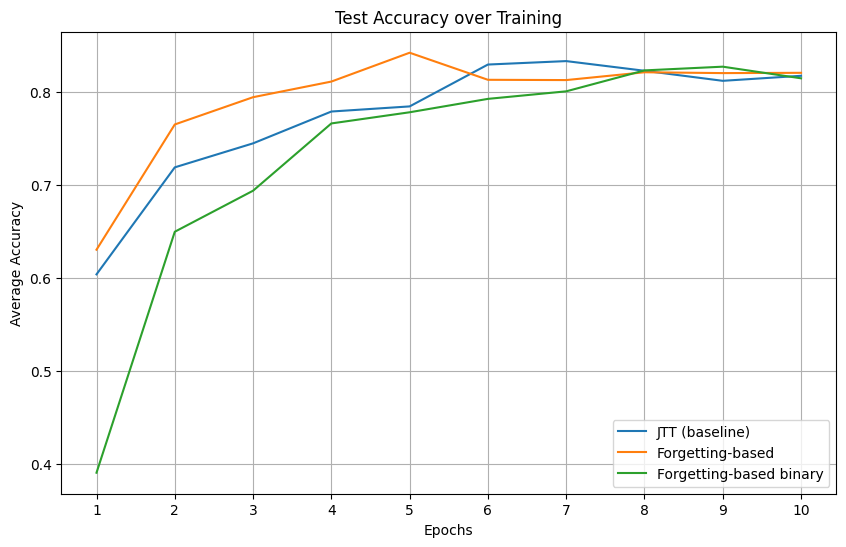

In [ ]:

import matplotlib.pyplot as plt

# Assuming test_acc_history_lst and test_acc_history_lst_forgetting are available

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
test_acc_history_lst_jtt_2 = np.array(test_acc_history_lst_jtt_2)
test_acc_history_lst_forgetting = np.array(test_acc_history_lst_forgetting)
test_acc_history_lst_forgetting_bin = np.array(test_acc_history_lst_forgetting_bin)
test_acc_history_lst= np.array(test_acc_history_lst)
plt.plot(epochs, [np.mean(test_acc_history_lst_jtt_2[i,:]) for i in range(test_acc_history_lst_jtt_2.shape[0])], label='JTT (baseline)')
plt.plot(epochs, [np.mean(test_acc_history_lst_forgetting[i,:]) for i in range(test_acc_history_lst_forgetting.shape[0])], label='Forgetting-based')
# plt.plot(epochs, [np.mean(test_acc_history_lst[i,:]) for i in range(test_acc_history_lst.shape[0])], label='Baseline')
plt.plot(epochs, [np.mean(test_acc_history_lst_forgetting_bin[i,:]) for i in range(test_acc_history_lst_forgetting_bin.shape[0])], label='Forgetting-based binary')

plt.xlabel('Epochs')
plt.ylabel('Average Accuracy')
plt.title('Test Accuracy over Training')
plt.legend()
plt.grid(True)
plt.xticks(epochs)

plt.show()

In [ ]:

evaluator = Evaluator(
    testset=testset,
    group_partition=testset.group_partition,
    group_weights=trainset.group_weights,
    batch_size=64,
    model=model,
    device=device,
    verbose=True
)
evaluator.evaluate()


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating group-wise accuracy:   4%|▍         | 1/25 [00:00<00:06,  3.69it/s]

Group (0, 0) Accuracy: 100.0


Evaluating group-wise accuracy:   8%|▊         | 2/25 [00:00<00:05,  3.85it/s]

Group (0, 1) Accuracy: 43.498817966903076


Evaluating group-wise accuracy:  12%|█▏        | 3/25 [00:00<00:05,  3.91it/s]

Group (0, 2) Accuracy: 61.938534278959814


Evaluating group-wise accuracy:  16%|█▌        | 4/25 [00:01<00:05,  3.81it/s]

Group (0, 3) Accuracy: 16.78486997635934


Evaluating group-wise accuracy:  20%|██        | 5/25 [00:01<00:05,  3.80it/s]

Group (0, 4) Accuracy: 71.63120567375887


Evaluating group-wise accuracy:  24%|██▍       | 6/25 [00:01<00:04,  3.81it/s]

Group (1, 0) Accuracy: 29.339853300733495


Evaluating group-wise accuracy:  28%|██▊       | 7/25 [00:01<00:05,  3.52it/s]

Group (1, 1) Accuracy: 100.0


Evaluating group-wise accuracy:  32%|███▏      | 8/25 [00:02<00:05,  3.05it/s]

Group (1, 2) Accuracy: 36.51960784313726


Evaluating group-wise accuracy:  36%|███▌      | 9/25 [00:02<00:06,  2.54it/s]

Group (1, 3) Accuracy: 22.058823529411764


Evaluating group-wise accuracy:  40%|████      | 10/25 [00:03<00:07,  1.97it/s]

Group (1, 4) Accuracy: 6.862745098039215


Evaluating group-wise accuracy:  44%|████▍     | 11/25 [00:04<00:08,  1.74it/s]

Group (2, 0) Accuracy: 25.066666666666666


Evaluating group-wise accuracy:  48%|████▊     | 12/25 [00:04<00:07,  1.68it/s]

Group (2, 1) Accuracy: 50.666666666666664


Evaluating group-wise accuracy:  52%|█████▏    | 13/25 [00:05<00:06,  1.86it/s]

Group (2, 2) Accuracy: 99.46666666666667


Evaluating group-wise accuracy:  56%|█████▌    | 14/25 [00:05<00:05,  2.07it/s]

Group (2, 3) Accuracy: 0.0


Evaluating group-wise accuracy:  60%|██████    | 15/25 [00:06<00:04,  2.38it/s]

Group (2, 4) Accuracy: 0.0


Evaluating group-wise accuracy:  64%|██████▍   | 16/25 [00:06<00:03,  2.67it/s]

Group (3, 0) Accuracy: 57.03517587939699


Evaluating group-wise accuracy:  68%|██████▊   | 17/25 [00:06<00:02,  2.91it/s]

Group (3, 1) Accuracy: 28.71536523929471


Evaluating group-wise accuracy:  72%|███████▏  | 18/25 [00:06<00:02,  3.04it/s]

Group (3, 2) Accuracy: 58.186397984886646


Evaluating group-wise accuracy:  76%|███████▌  | 19/25 [00:07<00:02,  2.87it/s]

Group (3, 3) Accuracy: 99.74811083123426


Evaluating group-wise accuracy:  80%|████████  | 20/25 [00:07<00:01,  2.79it/s]

Group (3, 4) Accuracy: 14.6095717884131


Evaluating group-wise accuracy:  84%|████████▍ | 21/25 [00:07<00:01,  3.05it/s]

Group (4, 0) Accuracy: 64.48362720403023


Evaluating group-wise accuracy:  88%|████████▊ | 22/25 [00:08<00:00,  3.26it/s]

Group (4, 1) Accuracy: 1.5113350125944585


Evaluating group-wise accuracy:  92%|█████████▏| 23/25 [00:08<00:00,  3.39it/s]

Group (4, 2) Accuracy: 0.0


Evaluating group-wise accuracy:  96%|█████████▌| 24/25 [00:08<00:00,  3.48it/s]

Group (4, 3) Accuracy: 13.383838383838384


Evaluating group-wise accuracy: 100%|██████████| 25/25 [00:08<00:00,  2.80it/s]

Group (4, 4) Accuracy: 99.74747474747475


{(0, 0): 100.0,
 (0, 1): 43.498817966903076,
 (0, 2): 61.938534278959814,
 (0, 3): 16.78486997635934,
 (0, 4): 71.63120567375887,
 (1, 0): 29.339853300733495,
 (1, 1): 100.0,
 (1, 2): 36.51960784313726,
 (1, 3): 22.058823529411764,
 (1, 4): 6.862745098039215,
 (2, 0): 25.066666666666666,
 (2, 1): 50.666666666666664,
 (2, 2): 99.46666666666667,
 (2, 3): 0.0,
 (2, 4): 0.0,
 (3, 0): 57.03517587939699,
 (3, 1): 28.71536523929471,
 (3, 2): 58.186397984886646,
 (3, 3): 99.74811083123426,
 (3, 4): 14.6095717884131,
 (4, 0): 64.48362720403023,
 (4, 1): 1.5113350125944585,
 (4, 2): 0.0,
 (4, 3): 13.383838383838384,
 (4, 4): 99.74747474747475}

In [ ]:

evaluator_2_forgetting = Evaluator(
    testset=testset,
    group_partition=testset.group_partition,
    group_weights=trainset.group_weights,
    batch_size=64,
    model=model_forgetting,
    device=device,
    verbose=True
)
evaluator_2_forgetting.evaluate()



Evaluating group-wise accuracy:   4%|▍         | 1/25 [00:00<00:06,  3.65it/s]

Group (0, 0) Accuracy: 100.0


Evaluating group-wise accuracy:   8%|▊         | 2/25 [00:00<00:06,  3.73it/s]

Group (0, 1) Accuracy: 95.27186761229315


Evaluating group-wise accuracy:  12%|█▏        | 3/25 [00:00<00:05,  3.75it/s]

Group (0, 2) Accuracy: 90.54373522458629


Evaluating group-wise accuracy:  16%|█▌        | 4/25 [00:01<00:05,  3.82it/s]

Group (0, 3) Accuracy: 95.0354609929078


Evaluating group-wise accuracy:  20%|██        | 5/25 [00:01<00:05,  3.79it/s]

Group (0, 4) Accuracy: 91.01654846335697


Evaluating group-wise accuracy:  24%|██▍       | 6/25 [00:01<00:04,  3.82it/s]

Group (1, 0) Accuracy: 74.32762836185819


Evaluating group-wise accuracy:  28%|██▊       | 7/25 [00:01<00:04,  3.75it/s]

Group (1, 1) Accuracy: 97.79951100244499


Evaluating group-wise accuracy:  32%|███▏      | 8/25 [00:02<00:04,  3.74it/s]

Group (1, 2) Accuracy: 83.57843137254902


Evaluating group-wise accuracy:  36%|███▌      | 9/25 [00:02<00:04,  3.78it/s]

Group (1, 3) Accuracy: 78.18627450980392


Evaluating group-wise accuracy:  40%|████      | 10/25 [00:02<00:03,  3.75it/s]

Group (1, 4) Accuracy: 58.57843137254902


Evaluating group-wise accuracy:  44%|████▍     | 11/25 [00:02<00:03,  3.67it/s]

Group (2, 0) Accuracy: 80.0


Evaluating group-wise accuracy:  48%|████▊     | 12/25 [00:03<00:03,  3.74it/s]

Group (2, 1) Accuracy: 79.73333333333333


Evaluating group-wise accuracy:  52%|█████▏    | 13/25 [00:03<00:03,  3.78it/s]

Group (2, 2) Accuracy: 98.13333333333334


Evaluating group-wise accuracy:  56%|█████▌    | 14/25 [00:03<00:02,  3.82it/s]

Group (2, 3) Accuracy: 76.53333333333333


Evaluating group-wise accuracy:  60%|██████    | 15/25 [00:04<00:02,  3.60it/s]

Group (2, 4) Accuracy: 56.149732620320854


Evaluating group-wise accuracy:  64%|██████▍   | 16/25 [00:04<00:02,  3.66it/s]

Group (3, 0) Accuracy: 80.40201005025126


Evaluating group-wise accuracy:  68%|██████▊   | 17/25 [00:04<00:02,  3.72it/s]

Group (3, 1) Accuracy: 76.32241813602015


Evaluating group-wise accuracy:  72%|███████▏  | 18/25 [00:04<00:01,  3.70it/s]

Group (3, 2) Accuracy: 82.61964735516372


Evaluating group-wise accuracy:  76%|███████▌  | 19/25 [00:05<00:01,  3.73it/s]

Group (3, 3) Accuracy: 97.73299748110831


Evaluating group-wise accuracy:  80%|████████  | 20/25 [00:05<00:01,  3.37it/s]

Group (3, 4) Accuracy: 73.55163727959697


Evaluating group-wise accuracy:  84%|████████▍ | 21/25 [00:05<00:01,  3.24it/s]

Group (4, 0) Accuracy: 80.60453400503778


Evaluating group-wise accuracy:  88%|████████▊ | 22/25 [00:06<00:01,  3.00it/s]

Group (4, 1) Accuracy: 63.476070528967256


Evaluating group-wise accuracy:  92%|█████████▏| 23/25 [00:06<00:00,  2.14it/s]

Group (4, 2) Accuracy: 62.97229219143577


Evaluating group-wise accuracy:  96%|█████████▌| 24/25 [00:07<00:00,  1.87it/s]

Group (4, 3) Accuracy: 75.5050505050505


Evaluating group-wise accuracy: 100%|██████████| 25/25 [00:08<00:00,  3.11it/s]

Group (4, 4) Accuracy: 98.23232323232324


{(0, 0): 100.0,
 (0, 1): 95.27186761229315,
 (0, 2): 90.54373522458629,
 (0, 3): 95.0354609929078,
 (0, 4): 91.01654846335697,
 (1, 0): 74.32762836185819,
 (1, 1): 97.79951100244499,
 (1, 2): 83.57843137254902,
 (1, 3): 78.18627450980392,
 (1, 4): 58.57843137254902,
 (2, 0): 80.0,
 (2, 1): 79.73333333333333,
 (2, 2): 98.13333333333334,
 (2, 3): 76.53333333333333,
 (2, 4): 56.149732620320854,
 (3, 0): 80.40201005025126,
 (3, 1): 76.32241813602015,
 (3, 2): 82.61964735516372,
 (3, 3): 97.73299748110831,
 (3, 4): 73.55163727959697,
 (4, 0): 80.60453400503778,
 (4, 1): 63.476070528967256,
 (4, 2): 62.97229219143577,
 (4, 3): 75.5050505050505,
 (4, 4): 98.23232323232324}

In [ ]:
evaluator_forget_bin = Evaluator(
    testset=testset,
    group_partition=testset.group_partition,
    group_weights=trainset.group_weights,
    batch_size=64,
    model=model_bin,
    device=device,
    verbose=True
)
evaluator_forget_bin.evaluate()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating group-wise accuracy:   4%|▍         | 1/25 [00:00<00:10,  2.35it/s]

Group (0, 0) Accuracy: 99.52718676122932


Evaluating group-wise accuracy:   8%|▊         | 2/25 [00:00<00:09,  2.44it/s]

Group (0, 1) Accuracy: 91.725768321513


Evaluating group-wise accuracy:  12%|█▏        | 3/25 [00:01<00:09,  2.42it/s]

Group (0, 2) Accuracy: 88.4160756501182


Evaluating group-wise accuracy:  16%|█▌        | 4/25 [00:01<00:08,  2.40it/s]

Group (0, 3) Accuracy: 87.70685579196217


Evaluating group-wise accuracy:  20%|██        | 5/25 [00:01<00:07,  2.60it/s]

Group (0, 4) Accuracy: 82.74231678486997


Evaluating group-wise accuracy:  24%|██▍       | 6/25 [00:02<00:06,  2.92it/s]

Group (1, 0) Accuracy: 77.01711491442543


Evaluating group-wise accuracy:  28%|██▊       | 7/25 [00:02<00:05,  3.11it/s]

Group (1, 1) Accuracy: 95.11002444987776


Evaluating group-wise accuracy:  32%|███▏      | 8/25 [00:02<00:05,  3.29it/s]

Group (1, 2) Accuracy: 75.24509803921569


Evaluating group-wise accuracy:  36%|███▌      | 9/25 [00:03<00:04,  3.38it/s]

Group (1, 3) Accuracy: 79.41176470588235


Evaluating group-wise accuracy:  40%|████      | 10/25 [00:03<00:04,  3.45it/s]

Group (1, 4) Accuracy: 67.6470588235294


Evaluating group-wise accuracy:  44%|████▍     | 11/25 [00:03<00:04,  3.32it/s]

Group (2, 0) Accuracy: 84.0


Evaluating group-wise accuracy:  48%|████▊     | 12/25 [00:04<00:04,  2.94it/s]

Group (2, 1) Accuracy: 74.13333333333334


Evaluating group-wise accuracy:  52%|█████▏    | 13/25 [00:04<00:03,  3.05it/s]

Group (2, 2) Accuracy: 98.66666666666667


Evaluating group-wise accuracy:  56%|█████▌    | 14/25 [00:04<00:03,  2.84it/s]

Group (2, 3) Accuracy: 82.4


Evaluating group-wise accuracy:  60%|██████    | 15/25 [00:05<00:03,  2.71it/s]

Group (2, 4) Accuracy: 63.903743315508024


Evaluating group-wise accuracy:  64%|██████▍   | 16/25 [00:05<00:03,  2.69it/s]

Group (3, 0) Accuracy: 87.68844221105527


Evaluating group-wise accuracy:  68%|██████▊   | 17/25 [00:05<00:02,  2.69it/s]

Group (3, 1) Accuracy: 85.39042821158691


Evaluating group-wise accuracy:  72%|███████▏  | 18/25 [00:06<00:02,  2.58it/s]

Group (3, 2) Accuracy: 68.26196473551637


Evaluating group-wise accuracy:  76%|███████▌  | 19/25 [00:06<00:02,  2.62it/s]

Group (3, 3) Accuracy: 98.2367758186398


Evaluating group-wise accuracy:  80%|████████  | 20/25 [00:07<00:01,  2.55it/s]

Group (3, 4) Accuracy: 81.86397984886649


Evaluating group-wise accuracy:  84%|████████▍ | 21/25 [00:07<00:01,  2.83it/s]

Group (4, 0) Accuracy: 80.60453400503778


Evaluating group-wise accuracy:  88%|████████▊ | 22/25 [00:07<00:00,  3.08it/s]

Group (4, 1) Accuracy: 69.0176322418136


Evaluating group-wise accuracy:  92%|█████████▏| 23/25 [00:07<00:00,  3.26it/s]

Group (4, 2) Accuracy: 55.415617128463474


Evaluating group-wise accuracy:  96%|█████████▌| 24/25 [00:08<00:00,  3.39it/s]

Group (4, 3) Accuracy: 61.111111111111114


Evaluating group-wise accuracy: 100%|██████████| 25/25 [00:08<00:00,  2.94it/s]

Group (4, 4) Accuracy: 98.23232323232324


{(0, 0): 99.52718676122932,
 (0, 1): 91.725768321513,
 (0, 2): 88.4160756501182,
 (0, 3): 87.70685579196217,
 (0, 4): 82.74231678486997,
 (1, 0): 77.01711491442543,
 (1, 1): 95.11002444987776,
 (1, 2): 75.24509803921569,
 (1, 3): 79.41176470588235,
 (1, 4): 67.6470588235294,
 (2, 0): 84.0,
 (2, 1): 74.13333333333334,
 (2, 2): 98.66666666666667,
 (2, 3): 82.4,
 (2, 4): 63.903743315508024,
 (3, 0): 87.68844221105527,
 (3, 1): 85.39042821158691,
 (3, 2): 68.26196473551637,
 (3, 3): 98.2367758186398,
 (3, 4): 81.86397984886649,
 (4, 0): 80.60453400503778,
 (4, 1): 69.0176322418136,
 (4, 2): 55.415617128463474,
 (4, 3): 61.111111111111114,
 (4, 4): 98.23232323232324}

In [ ]:

evaluator_3_jtt = Evaluator(
    testset=testset,
    group_partition=testset.group_partition,
    group_weights=trainset.group_weights,
    batch_size=64,
    model=model_jtt_2,
    device=device,
    verbose=True
)
evaluator_3_jtt.evaluate()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating group-wise accuracy:   4%|▍         | 1/25 [00:00<00:06,  3.53it/s]

Group (0, 0) Accuracy: 98.81796690307328


Evaluating group-wise accuracy:   8%|▊         | 2/25 [00:00<00:06,  3.64it/s]

Group (0, 1) Accuracy: 88.17966903073287


Evaluating group-wise accuracy:  12%|█▏        | 3/25 [00:00<00:05,  3.72it/s]

Group (0, 2) Accuracy: 92.19858156028369


Evaluating group-wise accuracy:  16%|█▌        | 4/25 [00:01<00:05,  3.56it/s]

Group (0, 3) Accuracy: 92.90780141843972


Evaluating group-wise accuracy:  20%|██        | 5/25 [00:01<00:06,  3.09it/s]

Group (0, 4) Accuracy: 89.36170212765957


Evaluating group-wise accuracy:  24%|██▍       | 6/25 [00:01<00:06,  2.78it/s]

Group (1, 0) Accuracy: 88.01955990220048


Evaluating group-wise accuracy:  28%|██▊       | 7/25 [00:02<00:06,  2.60it/s]

Group (1, 1) Accuracy: 99.26650366748166


Evaluating group-wise accuracy:  32%|███▏      | 8/25 [00:02<00:06,  2.63it/s]

Group (1, 2) Accuracy: 82.59803921568627


Evaluating group-wise accuracy:  36%|███▌      | 9/25 [00:03<00:06,  2.63it/s]

Group (1, 3) Accuracy: 82.3529411764706


Evaluating group-wise accuracy:  40%|████      | 10/25 [00:03<00:05,  2.58it/s]

Group (1, 4) Accuracy: 75.73529411764706


Evaluating group-wise accuracy:  44%|████▍     | 11/25 [00:03<00:05,  2.51it/s]

Group (2, 0) Accuracy: 82.13333333333334


Evaluating group-wise accuracy:  48%|████▊     | 12/25 [00:04<00:04,  2.67it/s]

Group (2, 1) Accuracy: 70.66666666666667


Evaluating group-wise accuracy:  52%|█████▏    | 13/25 [00:04<00:04,  2.92it/s]

Group (2, 2) Accuracy: 97.86666666666666


Evaluating group-wise accuracy:  56%|█████▌    | 14/25 [00:04<00:03,  3.14it/s]

Group (2, 3) Accuracy: 77.06666666666666


Evaluating group-wise accuracy:  60%|██████    | 15/25 [00:05<00:03,  3.30it/s]

Group (2, 4) Accuracy: 54.54545454545455


Evaluating group-wise accuracy:  64%|██████▍   | 16/25 [00:05<00:02,  3.37it/s]

Group (3, 0) Accuracy: 88.44221105527639


Evaluating group-wise accuracy:  68%|██████▊   | 17/25 [00:05<00:02,  3.48it/s]

Group (3, 1) Accuracy: 69.77329974811083


Evaluating group-wise accuracy:  72%|███████▏  | 18/25 [00:05<00:01,  3.50it/s]

Group (3, 2) Accuracy: 75.81863979848866


Evaluating group-wise accuracy:  76%|███████▌  | 19/25 [00:06<00:01,  3.50it/s]

Group (3, 3) Accuracy: 96.4735516372796


Evaluating group-wise accuracy:  80%|████████  | 20/25 [00:06<00:01,  3.51it/s]

Group (3, 4) Accuracy: 86.64987405541562


Evaluating group-wise accuracy:  84%|████████▍ | 21/25 [00:06<00:01,  3.52it/s]

Group (4, 0) Accuracy: 81.360201511335


Evaluating group-wise accuracy:  88%|████████▊ | 22/25 [00:07<00:00,  3.58it/s]

Group (4, 1) Accuracy: 36.523929471032744


Evaluating group-wise accuracy:  92%|█████████▏| 23/25 [00:07<00:00,  3.61it/s]

Group (4, 2) Accuracy: 57.9345088161209


Evaluating group-wise accuracy:  96%|█████████▌| 24/25 [00:07<00:00,  3.65it/s]

Group (4, 3) Accuracy: 74.4949494949495


Evaluating group-wise accuracy: 100%|██████████| 25/25 [00:07<00:00,  3.18it/s]

Group (4, 4) Accuracy: 98.23232323232324


{(0, 0): 98.81796690307328,
 (0, 1): 88.17966903073287,
 (0, 2): 92.19858156028369,
 (0, 3): 92.90780141843972,
 (0, 4): 89.36170212765957,
 (1, 0): 88.01955990220048,
 (1, 1): 99.26650366748166,
 (1, 2): 82.59803921568627,
 (1, 3): 82.3529411764706,
 (1, 4): 75.73529411764706,
 (2, 0): 82.13333333333334,
 (2, 1): 70.66666666666667,
 (2, 2): 97.86666666666666,
 (2, 3): 77.06666666666666,
 (2, 4): 54.54545454545455,
 (3, 0): 88.44221105527639,
 (3, 1): 69.77329974811083,
 (3, 2): 75.81863979848866,
 (3, 3): 96.4735516372796,
 (3, 4): 86.64987405541562,
 (4, 0): 81.360201511335,
 (4, 1): 36.523929471032744,
 (4, 2): 57.9345088161209,
 (4, 3): 74.4949494949495,
 (4, 4): 98.23232323232324}

In [ ]:
evaluator.worst_group_accuracy


((2, 3), 0.0)

In [ ]:
evaluator_2_forgetting.worst_group_accuracy


((2, 4), 56.149732620320854)

In [ ]:
evaluator_forget_bin.worst_group_accuracy


((4, 2), 55.415617128463474)

In [ ]:
evaluator_3_jtt.worst_group_accuracy

((4, 1), 36.523929471032744)